---
layout: code-post
title: Recurrent neural networks
tags: [neural nets]
---

By now a classicial and outdated technique, I am going to try to implement a
recurrent neural network and see how well it fits some dummy data.
A good resource for an overview of RNNs is [this cheat sheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks)
from a Stanford CS course.

Outline:
1. Architecture
2. Backpropagation through time (BTT)
3. Dummy training examples
4. LSTMs and other cell types

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

## 1. Architecture

RNNs are based on _cells_ and act on sequences of inputs. A single (simple) cell will take
two inputs: one element of the input sequence and either the output or the
_hidden state_ of the previous cell in the sequence. One can also take the two
inputs to be the output of the previous cell along with the hidden state of the 
previous cell if there is no longer an input sequence to rely upon. The many
variations can be found in the cheat sheet referenced above. A cell can also
take more than two inputs, as in the context of Long Short-Term Memory cells
there is an additional _context_ that exists in addition to the hidden state
that is passed between cells.

Let $x\_t$ be the $t$th element of the input sequence and $h\_{t-1}$ the
hidden state from the $(t-1)$st cell. Then the new hidden state is given
by
$$
    h\_t = \sigma(W\_{xh}x\_t + W\_{hh}h\_{t-1} + b\_h)
$$
where $\sigma$ is the activation function (we will take this to be ReLU).
If inpute sequence element $x\_t$ has dimension $n\_x$ and the hidden
state has size $n\_h$, then $W\_{xh}$ has size $n\_h\times n\_x$
while $W\_{hh}$ is a square matrix of size $n\_h\times n\_h$. This is equivalent
to
$$
    h\_t = \sigma([W\_{xh} | W\_{hh}](x\_t\oplus h\_{t-1} + b\_h)
$$
where$\oplus$ indicates vector concatenation and $[W\_{xh} | W\_{hh}]$ is a matrix
of size $n\_h \times(n\_x + n\_h)$. Many of the descriptions of RNNs, and in particular
when cells become more complicated as in _Long Short-Term Memory_ cells, formulate
things in terms of concatenation, so I just wanted to quickly show that these were
equivalent.

Moving forward, I will say that the hidden state is given by
$$
    h\_t = \sigma(W\_h(x\_t\oplus h\_{t-1}) + b\_h)
$$
where $W\_h$ has size $n\_h\times(n\_x + n\_h)$. Without working it out, my
intuition -- which could be wrong! -- suggests that this means we can keep
formulating the initialization in terms of the input and output vector sizes.

The output is then given by
$$
    y\_t = \sigma(W\_yh\_t + b\_y).
$$

All of these words are why you will usually just see diagrams when discussing
varieties of LSTMs.

The simplified version of an RNN would actually just take the hidden state and
the output to be the same, with no extra layer between the hidden
state and the output.

In the following code we implement a `Cell` class that initializes based on
input size, hidden state size, and output size. It has methods to take an
input and update the hidden state and update both the hidden state and its
output, which it stores. The updates can also return the inputs to the hidden
state neuron layer and the output neuron layers that are fed into the
ReLU and sigmoid activations, respectively.

In [2]:
def relu(x):
    return x * (x>0) + 0 * (x<=0)

def relu_prime(x):
    return 1 * (x>0) + 0 * (x<=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

class Cell():
    
    def __init__(self, input_size, hidden_size, output_size, random_seed=None):                 
        """ give the size of the input vectors, hidden state
        vectors, and output sizes. 
        
        If using the cells in such a way that the output is
        used in place of the hidden state, then hidden size and
        output size must be the same.
        
        If using in such a way that the output is used in place
        of the input at some point, then the output and input
        sizes must be the same.
        """
        np.random.seed(random_seed)
        
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        
        self._hidden_state = np.zeros((self._hidden_size, 1))
        self._y = np.zeros((self._output_size, 1))
        
        def initialize(nrows, ncols, init_type=None):
            # Kaiming He initialiation for weights
            # or just some arbitrary initialization for biases
            if ncols > 1:
                if init_type=='He':
                    std = np.sqrt(2.0 / ncols)
                elif init_type=='Xavier':
                    std = np.sqrt(2.0 / (ncols + nrows))
                else:
                    msg = 'init_type must be He or Xavier if initializing weights'
                    raise Exception(msg)
                    
                try_once = False
            else:
                # this is for biases
                std = np.sqrt(2.0 / nrows)
                try_once = nrows == 1
                
            if try_once:
                w = np.random.normal(0, std, size=(nrows, ncols))
            else:
                try_again = True
                while try_again:
                    w = np.random.normal(0, std, size=(nrows, ncols))
                    try_again = abs(np.std(w)-std) > .05 or abs(np.mean(w)) > .05
                
            return w
        
        self._wh = initialize(self._hidden_size, self._input_size + self._hidden_size, 'He')
        self._bh = initialize(self._hidden_size, 1)
        self._wy = initialize(self._output_size, self._hidden_size, 'Xavier')
        self._by = initialize(self._output_size, 1)
        
    @property
    def input_size(self):
        return self._input_size
    
    @property
    def hidden_size(self):
        return self._hidden_size
    
    @property
    def output_size(self):
        return self._output_size
    
    @property
    def hidden_state(self):
        return self._hidden_state
    
    def _shape_assert(self, oldval, newval):
        assert oldval.shape == newval.shape, \
            "new value must have shape {}".format(oldval.shape)
    
    @hidden_state.setter
    def hidden_state(self, val):
        self._shape_assert(self.hidden_state, val)
        self._hidden_state = val
        
    @property
    def y(self):
        return self._y
    
    @y.setter
    def y(self, val):
        self._shape_assert(self.y, val)
        self._y = val
        
    @property
    def wh(self):
        return self._wh
    
    @wh.setter
    def wh(self, val):
        self._shape_assert(self.wh, val)
        self._wh = val
        
    @property
    def bh(self):
        return self._bh
    
    @bh.setter
    def bh(self, val):
        self._shape_assert(self.bh, val)
        self._bh = val
        
    @property
    def wy(self):
        return self._wy
    
    @wy.setter
    def wy(self, val):
        self._shape_assert(self.wy, val)
        self._wy = val
        
    @property
    def by(self):
        return self._by
    
    @by.setter
    def by(self, val):
        self._shape_assert(self.by, val)
        self._by = val
        
    def update_hidden_state(self, x, return_activation_input=False):
        """ take a numpy vector of size (input_size, 1) and
        calculate the hidden state of size (hidden_size, 1).
        
        This returns nothing, updating in place. """
        
        assert type(x) == np.ndarray, "x must by numpy.ndarray"
        assert x.shape[0] == self.input_size, \
            "x must have first dim of length {}".format(self.input_size)
        assert x.shape[1] == 1, "x must have second dim of length 1"
        
        # concatenate
        xh = np.concatenate([x, self.hidden_state])
        
        # get output
        activation_input = np.matmul(self.wh, xh) + self.bh
        self.hidden_state = relu(activation_input)
        
        if return_activation_input:
            return activation_input
        else:
            return None
        
    def update_y(self, return_activation_input=False):
        """ takes the hidden state and runs through a neuron
        layer with sigmoid activation function to get the output y """
        activation_input = np.matmul(self.wy, self.hidden_state) + self.by
        self.y = sigmoid(activation_input)
        
        if return_activation_input:
            return activation_input
        else:
            return None
        
    def update(self, x, return_activation_inputs=False):
        hidden_layer_input = self.update_hidden_state(x, return_activation_inputs)
        output_layer_input = self.update_y(return_activation_inputs)
        
        if return_activation_inputs:
            return hidden_layer_input, output_layer_input
        else:
            return None
        
    def update_get_output(self, x):
        self.update(x, return_activation_inputs=False)
        return copy.deepcopy(self.y)

We now have an updatable cell that can be used to transform a sequence into
another sequence! We'll take a sequence that is defined by four other
fuzzy sequences of valeus coming from sine and cosine functions.
We'll just see what happens, that's all. This is just random playing around.

In [3]:
def func_sequence(func=np.sin, period_length=2*np.pi, periods=2, resolution=100, std=0.25, random_seed=None):
    """ returns a fuzzy periodic sequence using func """
    np.random.seed(random_seed)
    
    step = period_length / resolution
    x = np.arange(0, period_length * periods, step)
    y_exact = func(x)
    y_fuzzy = y_exact + np.random.normal(0, std, len(y_exact))
    
    return x, y_fuzzy

In [4]:
_, seq_1 = func_sequence()
_, seq_2 = func_sequence(np.cos)
_, seq_3 = func_sequence(lambda x: np.sin(x) * np.sin(x))
_, seq_4 = func_sequence(lambda x: np.sin(x) * np.cos(x))

input_seq = np.vstack([seq_1, seq_2, seq_3, seq_4]).reshape(-1, 4)

In [5]:
cell = Cell(4, 3, 1)

In [6]:
output_seq = np.array([cell.update_get_output(input_seq[i].reshape(4, -1))[0, 0] for i in range(len(input_seq))])

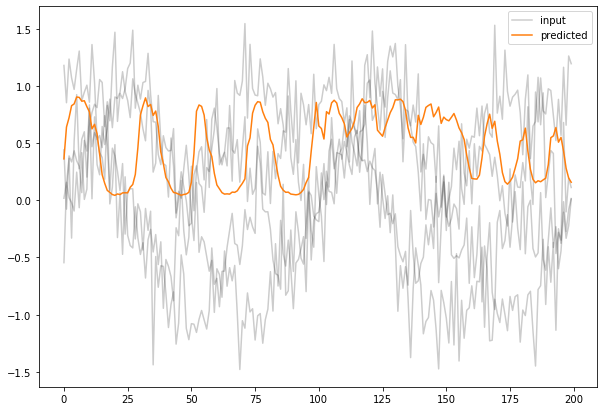

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))

x = range(len(input_seq))
ax.plot(seq_1, c='black', alpha=0.2)
ax.plot(seq_2, c='black', alpha=0.2)
ax.plot(seq_3, c='black', alpha=0.2)
ax.plot(seq_4, c='black', alpha=0.2, label='input')
ax.plot(output_seq, c='C1', label='predicted')
ax.legend()

plt.show()

All we've done is run a sequence of length 200 through the RNN. If we unrolled the RNN, it would
consist of a single layer of vanilla RNN cells of length 200, each of which gives an output
and feeds its hidden state into the next state. There's no learning here, I just wanted to 
demonstrate that the RNN code I've written works. Let's see what happens if we give a
constant input sequence for a few randomly initialized RNNs.

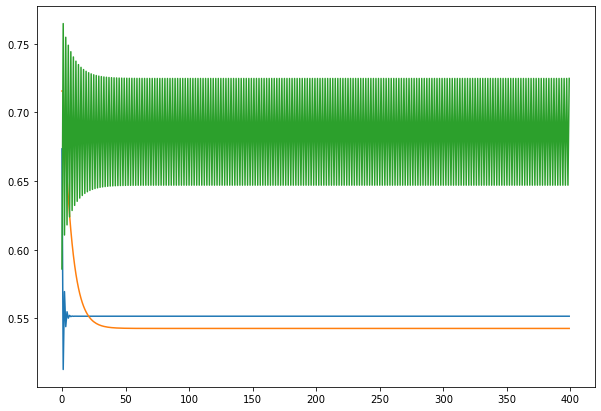

In [84]:
input_seq = np.ones((400, 4))

cell_1 = Cell(4, 3, 1, random_seed=4)
output_seq_1 = np.array([cell_1.update_get_output(input_seq[i].reshape(4, -1))[0, 0] for i in range(len(input_seq))])

cell_2 = Cell(4, 3, 1, random_seed=9)
output_seq_2 = np.array([cell_2.update_get_output(input_seq[i].reshape(4, -1))[0, 0] for i in range(len(input_seq))])

cell_3 = Cell(4, 3, 1, random_seed=10)
output_seq_3 = np.array([cell_3.update_get_output(input_seq[i].reshape(4, -1))[0, 0] for i in range(len(input_seq))])

fig, ax = plt.subplots(figsize=(10, 7))

x = range(len(input_seq))
ax.plot(output_seq_1)
ax.plot(output_seq_2)
ax.plot(output_seq_3)

plt.show()

Playing around with the random state gave me the three patterns observed above:

1. Brief osciallations before a constant
2. Gradually heading toward a constant
3. Oscillations that dampen to a constant amplitude

With constant input, we essentially are just acting on the hidden state
which starts out as all zeros. At every step the hidden state is acted
upon by an affine linear transformation (with the constant input forming a
part of the bias terms) and then the negative values are zeroed out by the
ReLU functions. This then gets passed as the next hidden state. The output
is an affine linear transformation of the hidden state that never changes.
So all we have to do is examine the behavior of repeatedly applying
a random affine linear transformation followed by zeroing out the negative values
in the result. Probably something about eigvenvalues of these randomly initialized
matrices (which will usually have small coefficients) that I don't wish to spend
my time deriving right now.

Thinking about unfolding the RNN in time, we have a single layer of cells.
It also possible to have multiple cells at a single timestep. At timestep
$t$ the first cell takes the intput $x\_t$ and the hidden state $h\_{t-1, 1}$
from the previous timestep of the same cells. The second cell would take
the output $y\_{t, 1}$ and its previous hidden state $h\_{t-1, 2}$ as its
input and put out the output $y\_t$. Unrolling this structure in time would
lead to multiple layers of cells. It seems that only one or two layers of cells
are typical, as training is very expensive for RNNs.

## 2. Backpropagation through time (BTT)

### Discussion of theory

Backpropagation through time is backpropagation on an unrolled recurrent
neural network. Since an RNN can be used on an arbitrary number of 
steps (depending on the application), one would limit the BTT algorithm
to the last couple time steps.

For an output sequence with $k$ steps, the overall loss is usually taken to be the
sum of the losses at each of the $k$ steps. Thus we can take the derivatives of
these step-wise losses and add them up to the get the derviatives of the
overall loss. This is another reason to limit BTT to the most recent couple
time steps and hope for the best, since this requires backpropagating through
many layers many times, which can be very costly.

Another necessary technique is [gradient clipping](http://proceedings.mlr.press/v28/pascanu13.pdf)
which replaces the calculated gradients with a rescaled version that
with a threshold value-- the authors of the linked paper use 1 as the 
threshold but say that one should look at the statistics of the gradient
to choose an appropriate threshold. Vanishing gradients are instead tackled
by changing the cell architecture from the vanilla RNN above to an
LSTM or Gated Reccurence Unit (GRU).

When calculating the gradient, note that there is a big difference
between calculating the gradient with respect to $W\_y$ and with respect
to $W\_h$. At timestep $k$, the matrix $W\_y$ only interacts one time
whereas $W\_h$ is involved in $k$ calculations, at least in the variant where
the hidden state and not the output is passed between RNN cells. Since I am
too lazy to upload a graphic myself, go look at [this blog post](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/)
or the many others that try to explain BTT in more detail than I am.

### Implementation

We're now going to choose a particular implementation of an RNN so that
we know how to implement BTT. We'll create a dummy example that mimics
a sentiment analysis classifier that takes in a sequence of fixed length
and predicts a single output, either 0 or 1. We'll take the sequence
length to be 10, because why not.

In [ ]:
class RNN():
    """ implement a simple RNN that takes a length N sequence of
    inputs and returns a single output, although inputs and ouputs
    can be various dimensions. 
    
    Architecture:
    
                  ^
                  |
    ( )-> ( ) -> ( )
     ^     ^      ^
     |     |      |
    
    """
    
    def __init__(self,
                 input_seq_length=10,
                 input_size=5,
                 hidden_size=3,
                 output_size=1):
        
        self._cell = Cell(input_size, hidden_size, output_size)
        self._input_seq_length = input_seq_length
        self._hidden_size = hidden_size
        
        
    @property
    def cell(self):
        return self._cell
    
    @property
    def input_seq_length(self):
        return self._intput_seq_length
    
    @property
    def hidden_size(self):
        return self._hidden_size
    
    def _forward_pass(self, x):
        """ x is a sequence of length  n"""
        
        hidden_states = np.zeros((self.input_seq_length, self.hidden_size, 1))
        hidden_activation_inputs = []

In [87]:
np.zeros((2, 5, 1))[0].shape

(5, 1)